# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley, 2016

# 1) Monty: The Python Siri

Let's make a Siri-like program with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/fall2016/ay250/resources -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [24]:
# Import
from pyaudio import PyAudio
from pyaudio import paFloat32
from pyaudio import paContinue
from time import sleep
from numpy import array, random, arange, float32, float64, zeros
import matplotlib.pyplot as plt

In [26]:
# References: 

# http://samcarcagno.altervista.org/blog/basic-sound-processing-python/

# https://gist.github.com/endolith/255291

# http://www.cs.tut.fi/sgn/arg/intro/basics.html

# https://github.com/endolith/waveform-analyzer/blob/master/frequency_estimator.py

In [3]:
################################### Constants ##################################

fs            = 44100   # Hz
threshold     = 0.8     # absolute gain
delay         = 40      # samples
signalLength  = 1       # second
relCoeff      = 0.9999  # release time factor
attCoeff      = 0.9     # attack time factor
dtype         = 'float32' # default data type
blockLength   = 1024    # samples

In [4]:

#################### Generate quiet-loud-quiet noise signal ####################

signal = array(random.rand(fs * signalLength) * 2 - 1, dtype = dtype)
signal[:signalLength * fs / 3] *= 0.1
signal[signalLength * fs * 2 / 3:] *= 0.1

/Users/kschocz/Library/Python/3.5/lib/python/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/kschocz/Library/Python/3.5/lib/python/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
class AudioLimiter(object):
    
    def __init__(self, attCoeff, relCoeff, delay, dtype = 'float32'):
        self.delayIdx = 0
        self.env = 0
        self.gain = 1
        self.delay = delay
        self.delayLine = zeros(delay, dtype = dtype)
        self.attCoeff = attCoeff
        self.relCoeff = relCoeff
        
    def getLimit(self, signal, threshold):
        for i in arange(len(signal)):
            self.delayLine[self.delayIdx] = signal[i]
            self.delayIdx = (self.delayIdx + 1) % self.delay
            
            # Calc env of signal
            self.env *= self.relCoeff
            self.env = max(abs(signal[i]), self.env)
            
            # Gain moves towards limiter gain
            if(self.env > threshold):
                targetGain = (1 + threshold - self.env)
            else:
                targetGain = 1.0
            self.gain = (self.gain * self.attCoeff + targetGain * (1 - self.attCoeff))
            
            # Limit the delayed signal
            signal[i] = self.delayLine[self.delayIdx] * self.gain

In [19]:
def callback(dIn, frameCount, timeInfo, flag):
    if(flag):
        print("Playback error: %i" % flag)
    global counter
    playedFrames = counter
    counter += frameCount
    audioLimit.getLimit(signal[playedFrames:counter], threshold)
    return signal[playedFrames:counter], paContinue

#callback.counter = 0
counter = 0

In [20]:
originalSignal = array(signal, copy = True, dtype = dtype)

audioLimit = AudioLimiter(attCoeff, relCoeff, delay, dtype) 

In [21]:
pa = PyAudio()

In [22]:

# Real-time audio processing
audioStream = pa.open(format = paFloat32,
                     channels = 1,
                     rate = 44100,
                     output = True,
                     frames_per_buffer = 1024,
                     stream_callback = callback)

while audioStream.is_active():
    sleep(0.1)
    
audioStream.close()
pa.terminate()

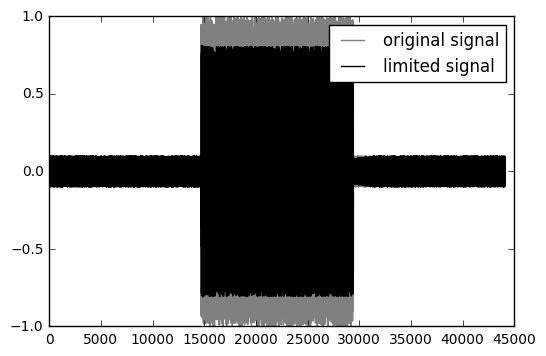

In [23]:
plt.figure()
plt.plot(originalSignal, color = 'grey', label = 'original signal')
plt.plot(signal, color = 'black', label = 'limited signal')
plt.legend()
plt.show(block = True)

In [ ]:
### Alternative way to save plots 

from numpy import *
from matplotlib.pyplot import *

random.seed(0)
noise = random.randn(5000)
noise /= max(noise)
envelope = zeros(5000)
gain = ones(5000)

threshold = 0.85

for i in arange(len(noise)):
    envelope[i] = max(abs(envelope[i-1]) * 0.9998, abs(noise[i]))
    if envelope[i] > threshold:
        target_gain = 1.0 + threshold - envelope[i]
    else:
        target_gain = 1.0
    gain[i] = gain[i-1]*0.8 + target_gain*(1-0.8)

figure(figsize=(5,2.5))
plot(abs(noise), color='lightgrey', label='|noise|')
plot(envelope, color='black', linewidth=2, label='envelope')
xlabel('time/samples')
xticks(())
ylabel('gain/linear')
yticks(())
legend(loc='lower right')
tight_layout()
savefig('envelope.png')

plot((0, len(noise)),(threshold,threshold), color='grey', linewidth=2)
plot(gain-(1-threshold), color='red', linewidth=2, label='gain')
legend(loc='lower right')
savefig('gain.png')

xlim(3000,3200)
ylim(0.6,1.1)
legend().set_visible(False)
savefig('detail.png')